<b><font size="6">|032|Regression|Vehicle Price Prediction with No Processing</font></b>

* **Author**: Dino Giovannoni
* **Date:**: 16-April-2025

Based on dataset: https://www.kaggle.com/datasets/nehalbirla/vehicle-dataset-from-cardekho/data
Notebook based on: 
 - https://www.kaggle.com/code/farzadnekouei/polynomial-regression-regularization-assumptions
 - https://www.kaggle.com/code/mohaiminul101/car-price-prediction

# Import Libraries

In [27]:
import numpy as np 
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the Data

In [28]:
df = pd.read_csv('car data.csv')

## Inspect the first 5 rows

In [29]:
display(df.head())

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


## Inspect information about the dataframe 

Provide a list of the DataFrame columns and the data types in each of the columns.

In [30]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


None

# Data Processing & Exploratory Data Analysis

## View the Descriptive Statistics

Extract various descriptive statistics from the dataset, including the mean/standard deviation, mmin, max, etc.

In [31]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
Year,301.0,2013.627907,2.891554,2003.00,2012.0,2014.0,2016.0,2018.0
Selling_Price,301.0,4.661296,5.082812,0.10,0.9,3.6,6.0,35.0
Present_Price,301.0,7.628472,8.644115,0.32,1.2,6.4,9.9,92.6
Kms_Driven,301.0,36947.205980,38886.883882,500.00,15000.0,32000.0,48767.0,500000.0
Owner,301.0,0.043189,0.247915,0.00,0.0,0.0,0.0,3.0


## Feature Selection

In [ ]:
display(df.describe(include='object').T)

,count,unique,top,freq
Car_Name,301,98,city,26
Fuel_Type,301,3,Petrol,239
Seller_Type,301,2,Dealer,195
Transmission,301,2,Manual,261


Since Car_Name contains 98 unique categories, and this number of categories is very high compared to the number of dataset samples, it is better to drop it:

In [33]:
df.drop('Car_Name', axis=1, inplace=True)

We can determine which are the numerical and categorical features:

In [34]:
output_var = 'Selling_Price'
numeric_data = df.select_dtypes(include=['number']).columns.tolist()
numeric_features = [col for col in numeric_data if col != output_var]
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

print(f'Numeric Features    : {numeric_features}')
print(f'Categorical Features: {categorical_features}')

Numeric Features    : ['Year', 'Present_Price', 'Kms_Driven', 'Owner']
Categorical Features: ['Fuel_Type', 'Seller_Type', 'Transmission']


## Histograms of Numerical Raw Features

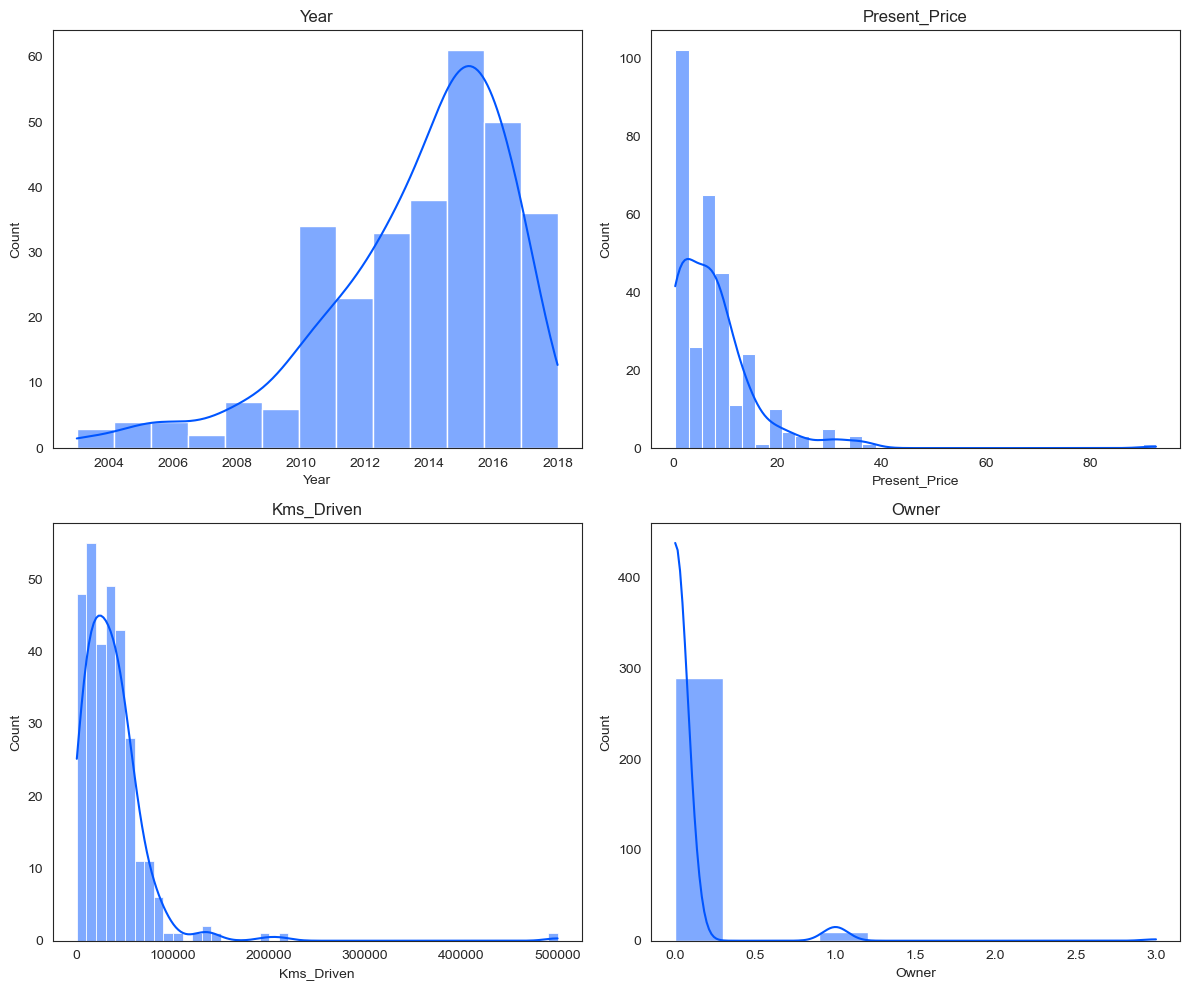

In [35]:
plt.figure(figsize=(12, 10))
for i, col in enumerate(df[numeric_features].columns):
    plt.subplot(2, 2, i+1)
    sns.histplot(df[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

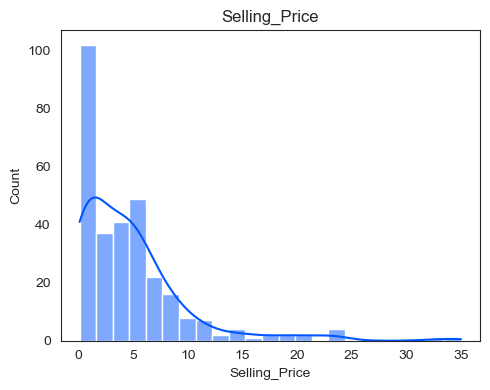

In [36]:
plt.figure(figsize=(5, 4))
sns.histplot(df[output_var], kde=True)
plt.title(output_var)
plt.tight_layout()
plt.show()

### Box Plots of Transformed Numeric Features

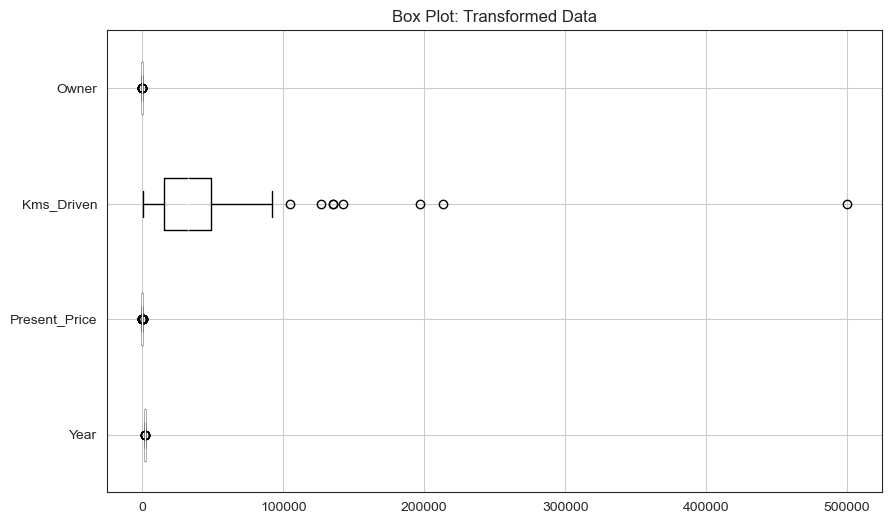

In [37]:
fig, ax = plt.subplots(figsize=(10, 6))
boxplot = df[numeric_features].boxplot(vert = 0, ax=ax)  
_ = ax.set_title(f'Box Plot: Transformed Data')

## Categorical Data

In [38]:
print(f'Categorical Features: {categorical_features}')

Categorical Features: ['Fuel_Type', 'Seller_Type', 'Transmission']


In [39]:
display(df.describe(include='object').T)

,count,unique,top,freq
Fuel_Type,301,3,Petrol,239
Seller_Type,301,2,Dealer,195
Transmission,301,2,Manual,261


### Frequency Distributions

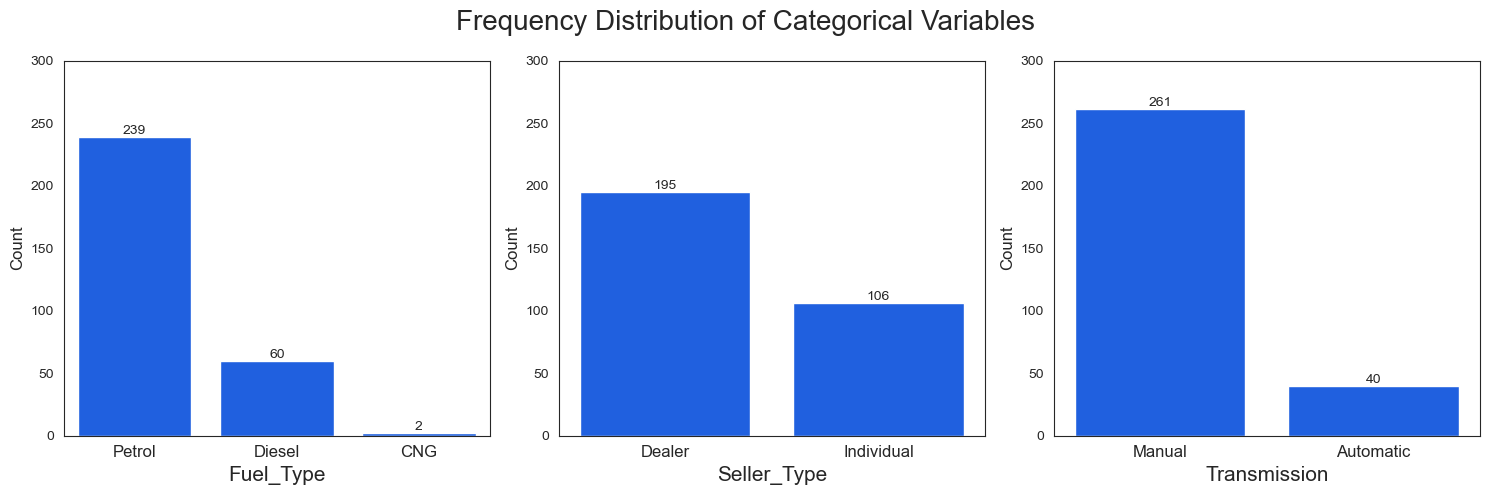

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5), dpi=100)
colors = ['#0055ff', '#ff7000', '#23bf00']
CustomPalette = sns.set_palette(sns.color_palette(colors))
       
for i in range(len(categorical_features)):
    graph = sns.countplot(x=categorical_features[i], data=df, ax=ax[i])
    ax[i].set_xlabel(categorical_features[i], fontsize=15)
    ax[i].set_ylabel('Count', fontsize=12)
    ax[i].set_ylim([0,300])
    ax[i].tick_params(axis='x', labelsize=12)
    for cont in graph.containers:
        graph.bar_label(cont)

plt.suptitle('Frequency Distribution of Categorical Variables', fontsize=20) 
plt.tight_layout()
plt.show()

### Categorical Variables Encoding

We implement dummy encoding on categorical columns, since they are all nominal variables:

In [41]:
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)
df.head(5)

,Year,Selling_Price,Present_Price,Kms_Driven,Owner,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
0,2014,3.35,5.59,27000,0,False,True,False,True
1,2013,4.75,9.54,43000,0,True,False,False,True
2,2017,7.25,9.85,6900,0,False,True,False,True
3,2011,2.85,4.15,5200,0,False,True,False,True
4,2014,4.60,6.87,42450,0,True,False,False,True


## Create Scatter Plots of Data

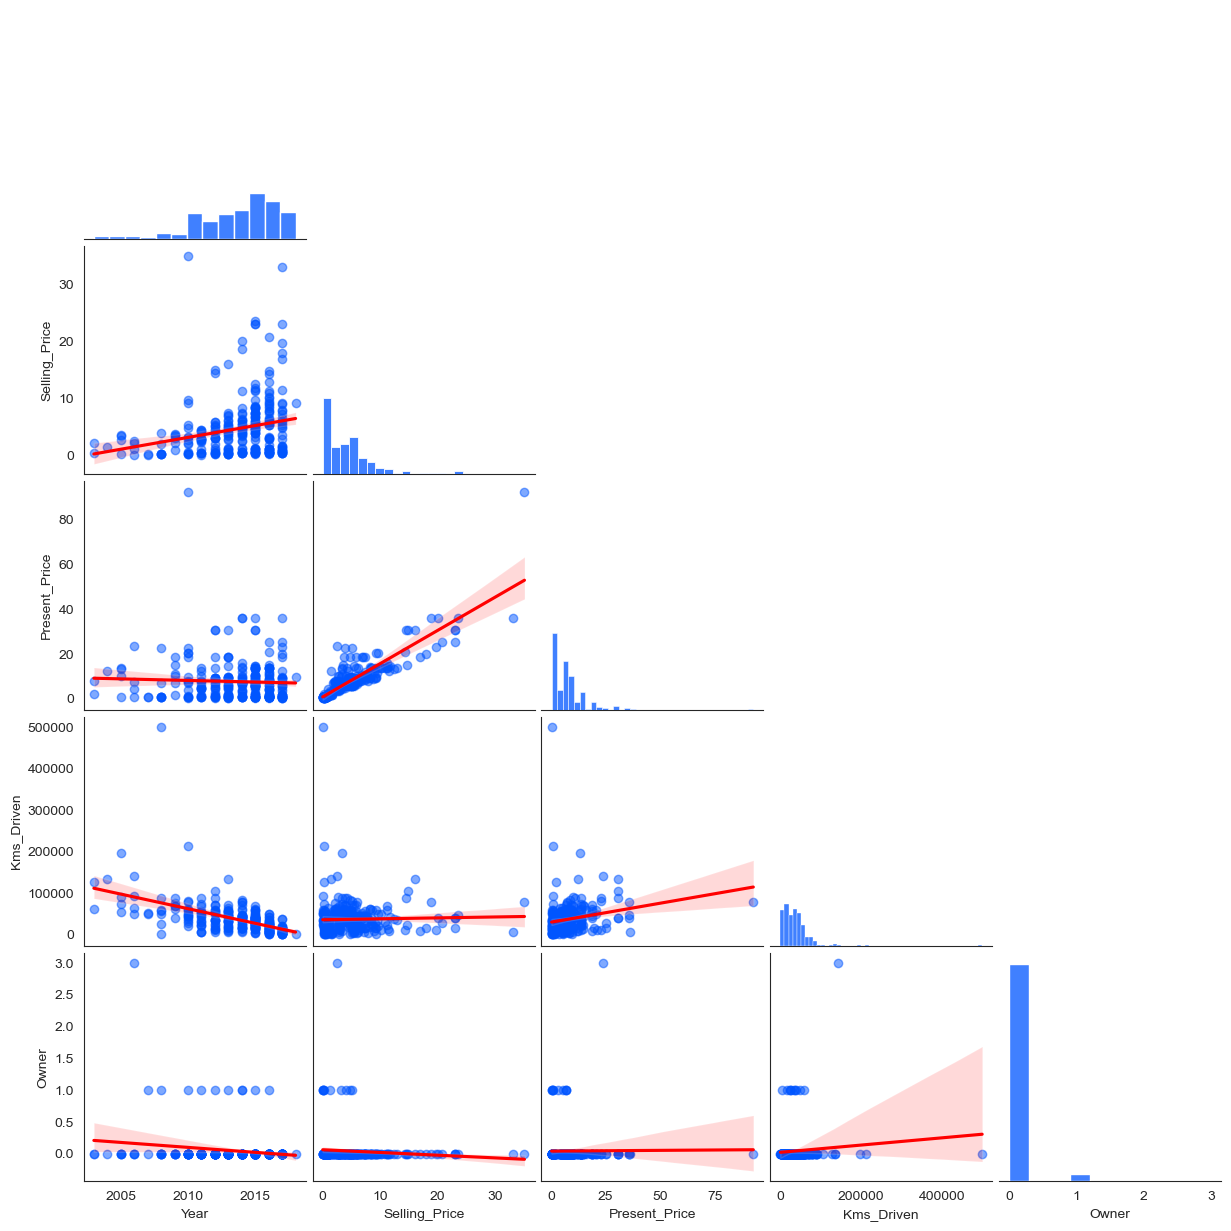

In [42]:
_ = sns.pairplot(data = df[numeric_data], 
                 corner = True, 
                 kind='reg',
                 plot_kws={'line_kws': {'color': 'red'}, 'scatter_kws': {'alpha': 0.5}})

## Calculate the correlation coeffients

In [43]:
def CorrPlot(df, dropDuplicates = True, figsize = (8, 6)):
    # df = df.corr()
    df = np.abs(df.corr())
    # Exclude duplicate correlations by masking upper right values
    if dropDuplicates:    
        mask = np.zeros_like(df, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
    # Set background color / chart style
    sns.set_style(style = 'white')
    # Set up  matplotlib figure
    f, ax = plt.subplots(figsize=figsize)
    # Add diverging colormap from red to blue
    cmap = sns.diverging_palette(250, 10, as_cmap=True)
    # Draw correlation plot with or without duplicates
    if dropDuplicates:
        sns.heatmap(df, mask=mask, cmap=cmap, 
                    annot=True,
                    square=True,
                    linewidth=.5, cbar_kws={"shrink": .75}, ax=ax)
    else:
        sns.heatmap(df, cmap=cmap, 
                square=True,
                annot=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)

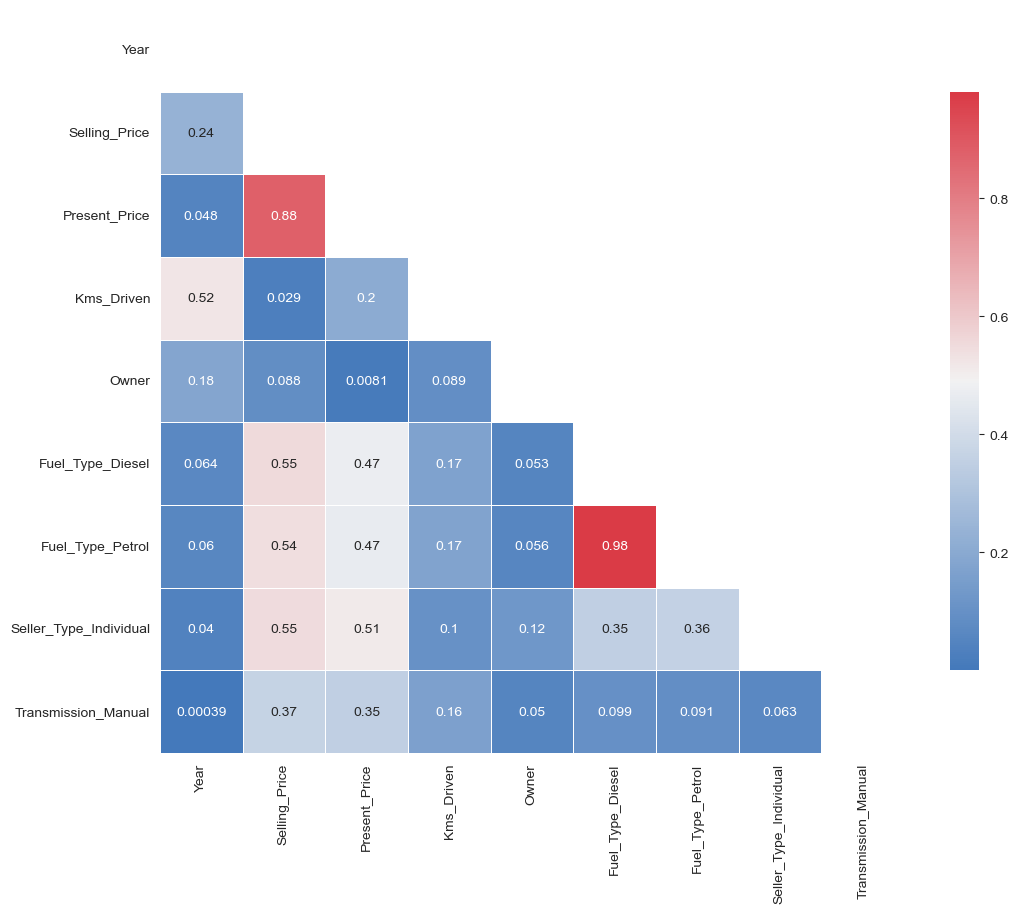

In [44]:
CorrPlot(df, figsize = (12, 10))

# Linear Regression Model

## Extract features & define input and output variables

In [45]:
features = df.columns.drop(output_var).to_list()
X = df[features]
y = df[output_var]
display(X, y)

,Year,Present_Price,Kms_Driven,Owner,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
0,2014,5.59,27000,0,False,True,False,True
1,2013,9.54,43000,0,True,False,False,True
2,2017,9.85,6900,0,False,True,False,True
3,2011,4.15,5200,0,False,True,False,True
4,2014,6.87,42450,0,True,False,False,True
...,...,...,...,...,...,...,...,...
296,2016,11.60,33988,0,True,False,False,True
297,2015,5.90,60000,0,False,True,False,True
298,2009,11.00,87934,0,False,True,False,True
299,2017,12.50,9000,0,True,False,False,True


0       3.35
1       4.75
2       7.25
3       2.85
4       4.60
       ...  
296     9.50
297     4.00
298     3.35
299    11.50
300     5.30
Name: Selling_Price, Length: 301, dtype: float64

## Split data into training and test

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=90)

## Regression Model

In [47]:
model = LinearRegression().fit(X_train, y_train)

## Perform Predictions

In [48]:
y_train_pred = model.predict(X_train)
y_test_pred  = model.predict(X_test)

# Model Evaluation

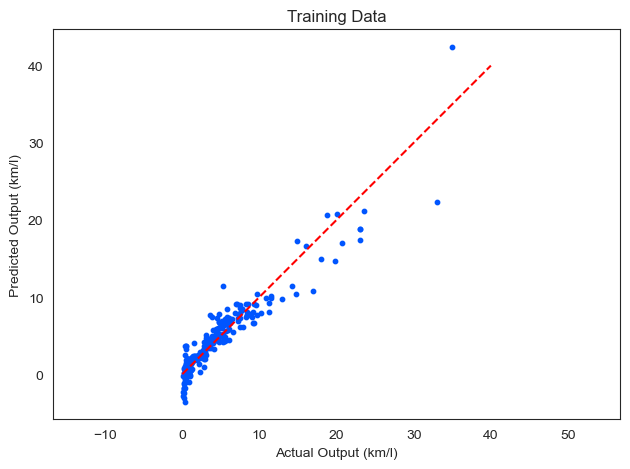

In [49]:
plt.scatter(y_train, y_train_pred, s=10)
plt.plot([0, 40], [0,40], color = 'red', linestyle='dashed')

plt.xlabel('Actual Output (km/l)')
plt.ylabel('Predicted Output (km/l)')
plt.axis('equal')
plt.title('Training Data')
plt.tight_layout()

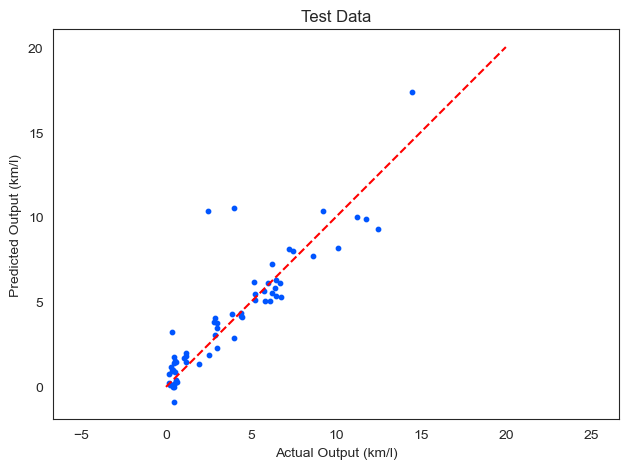

In [50]:
plt.scatter(y_test, y_test_pred, s=10)
plt.plot([0, 20], [0,20], color = 'red', linestyle='dashed')
plt.xlabel('Actual Output (km/l)')
plt.ylabel('Predicted Output (km/l)')
plt.axis('equal')
plt.title('Test Data')
plt.tight_layout()

## Calculating the metrics

In [51]:
train_mae =  np.round(mean_absolute_error(y_train, y_train_pred),3 )
train_mse =  np.round(mean_squared_error(y_train, y_train_pred),3)
train_rmse = np.round(np.sqrt(train_mse),3)

print('COMPARISON OF METRICS - TRAINING DATA')
print(f'Training MAE   : {train_mae}')
print(f'Training MSE   : {train_mse}')
print(f'Training RMSE  : {train_rmse}')

COMPARISON OF METRICS - TRAINING DATA
Training MAE   : 1.228
Training MSE   : 3.264
Training RMSE  : 1.807


In [52]:
test_mae =  np.round(mean_absolute_error(y_test, y_test_pred),3) 
test_mse =  np.round(mean_squared_error(y_test, y_test_pred),3)
test_rmse = np.round(np.sqrt(test_mse),3)

print('COMPARISON OF METRICS - TEST DATA')
print(f'Testing MAE   : {test_mae}')
print(f'Testing MSE   : {test_mse}')
print(f'Testing RMSE  : {test_rmse}')

COMPARISON OF METRICS - TEST DATA
Testing MAE   : 1.001
Testing MSE   : 2.747
Testing RMSE  : 1.657
